In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import pandas as pd
import numpy as np
from tqdm import tqdm
from ste import STE

# Time-series dataset

In [2]:
# Define the country name.
COUNTRY = "Syria"

In [3]:
PATH_TO_DATA_FOLDER = "../Dataset time-series/output_data/" + COUNTRY + "/"

In [4]:
# Load the time-series dataset.
df = pd.read_csv(PATH_TO_DATA_FOLDER + "%s-day.csv" % COUNTRY, header = [0, 1], index_col = 0)
df.index.name = "Datetime"
df.index = pd.to_datetime(df.index)
freq = "D"
df.index.freq = freq

In [5]:
df.columns.get_level_values(1).unique()

Index(['1 Month Anomaly Rainfalls (%)', '3 Months Anomaly Rainfalls (%)',
       'Code', 'Exchange rate', 'FCG <= 2', 'Fatalities', 'Lat', 'Lon', 'NDVI',
       'NDVI Anomaly', 'Population', 'Price cereals and tubers',
       'Rainfalls (mm)', 'Ramadan', 'rCSI >= 19'],
      dtype='object', name='Indicator')

In [6]:
# Consider only some indicators for the analysis with symbolic transfer entropy.
INDICATORS_TO_CONSIDER = ["FCG <= 2", "1 Month Anomaly Rainfalls (%)", "3 Months Anomaly Rainfalls (%)", "NDVI", "Price cereals and tubers", "Exchange rate", "Fatalities", "NDVI Anomaly", "rCSI >= 19", "Rainfalls (mm)"]
df = pd.concat([df.loc[:, (slice(None), feature)] for feature in INDICATORS_TO_CONSIDER], axis = 1).sort_index(axis = 1)
df

AdminStrata                    Al-Hasakeh                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
Datetime                                                                   
2018-09-29                      99.920932                     103.281473   
2018-09-30                      99.894768                     102.581411   
2018-10-01                      99.936859                     102.137474   
2018-10-02                     100.047045                     101.810225   
2018-10-03                     100.225326                     101.599662   
...                                   ...                            ...   
2020-08-31                     100.000000                     101.956171   
2020-09-01                     100.000129                     101.497542   
2020-09-02                     100.000387                     101.139241   
2020-09-03                     100.000774                     100.881269   
2020-09-04                     100.001290                     100.723624   

AdminStrata                                                            \
Indicator   Exchange rate  FCG <= 2 Fatalities      NDVI NDVI Anomaly   
Datetime                                                                
2018-09-29       0.017435  36.83872      111.0  0.117052    89.349382   
2018-09-30       0.017595  36.83872      101.0  0.116985    89.326130   
2018-10-01       0.017870  36.49929       99.0  0.116915    89.301813   
2018-10-02       0.017985  36.37038       97.0  0.116842    89.275320   
2018-10-03       0.018099  38.25699       85.0  0.116765    89.246651   
...                   ...       ...        ...       ...          ...   
2020-08-31       0.783499  43.16290       75.0  0.150221   108.031057   
2020-09-01       0.785452  44.98382       75.0  0.150224   107.919379   
2020-09-02       0.787405  44.30129       75.0  0.150232   107.818228   
2020-09-03       0.789357  48.09989       70.0  0.150245   107.727603   
2020-09-04       0.791310  47.02155       66.0  0.150265   107.647505   

AdminStrata                                                     ...  \
Indicator   Price cereals and tubers Rainfalls (mm) rCSI >= 19  ...   
Datetime                                                        ...   
2018-09-29                  0.057275         0.1372   34.05440  ...   
2018-09-30                  0.057331         0.1500   34.05440  ...   
2018-10-01                  0.057651         0.7876   33.67614  ...   
2018-10-02                  0.057914         1.4245   31.54574  ...   
2018-10-03                  0.058178         2.0614   32.76720  ...   
...                              ...            ...        ...  ...   
2020-08-31                  0.528965         0.0000   51.48633  ...   
2020-09-01                  0.529923         0.0006   54.04531  ...   
2020-09-02                  0.530881         0.0012   53.22101  ...   
2020-09-03                  0.531840         0.0018   50.27144  ...   
2020-09-04                  0.532798         0.0024   52.59823  ...   

AdminStrata                       Tartous                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
Datetime                                                                   
2018-09-29                     113.829315                     179.577637   
2018-09-30                     113.631431                     173.128816   
2018-10-01                     113.462981                     166.727201   
2018-10-02                     113.241732                     160.712897   
2018-10-03                     112.967684                     155.085903   
...                                   ...                            ...   
2020-08-31                     100.553289                     110.028605   
2020-09-01                     100.589511                     110.620376   
2020-09-02                     100.622048                     111.154853   
2020-

In [7]:
PROVINCES = df.columns.get_level_values(0).unique()
PROVINCES

Index(['Al-Hasakeh', 'Aleppo', 'Ar-Raqqa', 'As-Sweida', 'Damascus', 'Dar'a',
       'Hama', 'Homs', 'Lattakia', 'Rural Damascus', 'Tartous'],
      dtype='object', name='AdminStrata')

In [8]:
PREDICTORS = df.columns.get_level_values(1).unique()
PREDICTORS

Index(['1 Month Anomaly Rainfalls (%)', '3 Months Anomaly Rainfalls (%)',
       'Exchange rate', 'FCG <= 2', 'Fatalities', 'NDVI', 'NDVI Anomaly',
       'Price cereals and tubers', 'Rainfalls (mm)', 'rCSI >= 19'],
      dtype='object', name='Indicator')

In [9]:
# Assign a color to each indicator.
#cols = plt.get_cmap("tab10")
cols = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
        (1.0, 0.4980392156862745, 0.054901960784313725),
        (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
        (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
        (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
        (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
        (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
        (0.09019607843137255, 0.7450980392156863, 0.8117647058823529), 
        (1.0, 1.0, 0.2), 
        (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

colors = dict()
for i,indicator in enumerate(reversed(PREDICTORS)):
    #colors[indicator] = cols(i)
    colors[indicator] = cols[i]

# Importance of the indicators

In [10]:
df_feature_importance = df.drop("FCG <= 2", axis = 1, level = 1)

In [11]:
rows_ste = list()
rows_ste_rank = list()

def feature_importance(group):
    adminstrata = group.name
    rows = dict()
    for indicator in df_feature_importance.columns.get_level_values(1).unique():
        result = STE.calc_ste(group[adminstrata][indicator], df[adminstrata]["FCG <= 2"], m = 3, kx = 1, ky = 1, h = 1)
        rows[indicator] = result
    row = pd.Series(rows)
    row.name = adminstrata + " - FCG $\leq$ 2"
    rows_ste.append(row)
    rows_ste_rank.append(row.rank(method = "max", ascending = False))

tqdm.pandas()
df_feature_importance.groupby(level = 0, axis = 1).progress_apply(feature_importance);
T_fcs = pd.concat(rows_ste, axis = 1).transpose()
T_fcs_rank = pd.concat(rows_ste_rank, axis = 1).transpose()

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.88it/s]


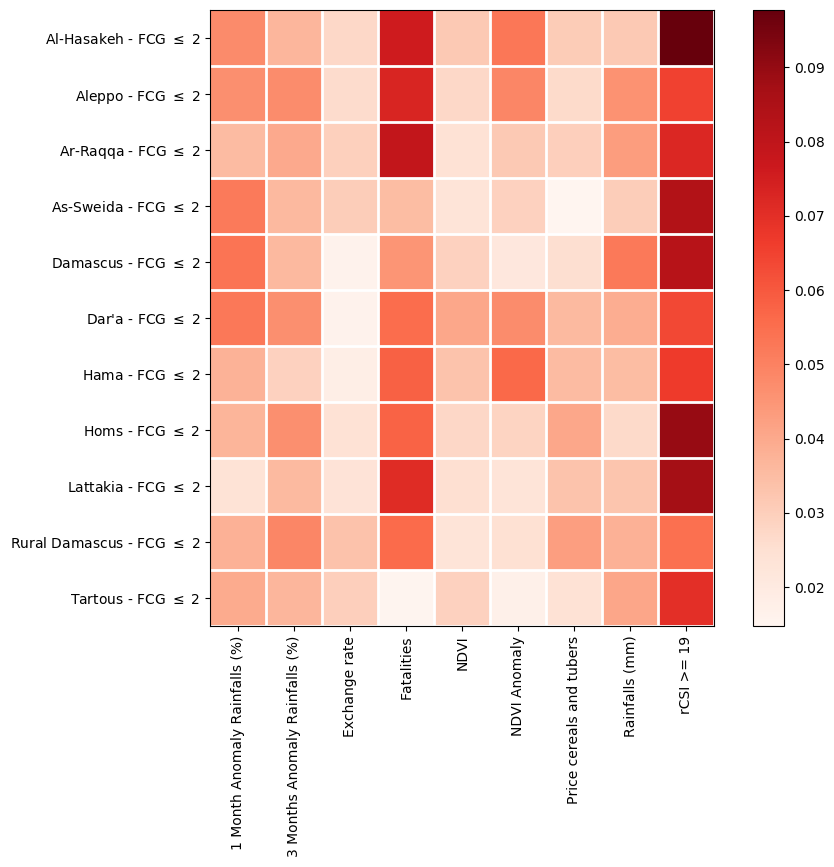

In [12]:
with plt.style.context("default"):
    fig, ax = plt.subplots(figsize = (10, 8))
    im = ax.imshow(T_fcs.astype(float), cmap = "Reds")
    cbar = fig.colorbar(im, ax = ax)
    #clb = plt.colorbar()
    #cbar.set_label("STE", rotation = 270)

    ax.set_xticks(range(len(T_fcs.columns)))
    ax.set_yticks(range(len(T_fcs.index)))
    ax.set_xticklabels(T_fcs.columns, rotation = 90)
    ax.set_yticklabels(T_fcs.index)
    #ax.set_xlabel("Indicator")
    #ax.set_ylabel("AdminStrata")
    #ax.set_title("T - Influence different indicators for FCS")
    for i in range(T_fcs.shape[0]):
        ax.axhline(i + 0.5, color = "white", lw = 2)
    for i in range(T_fcs.shape[1]):
        ax.axvline(i + 0.5, color = "white", lw = 2)
        
    # Save the figure.
    fig.savefig("./output_images/Importance_%s.png" % COUNTRY, bbox_inches = "tight", dpi = 300)

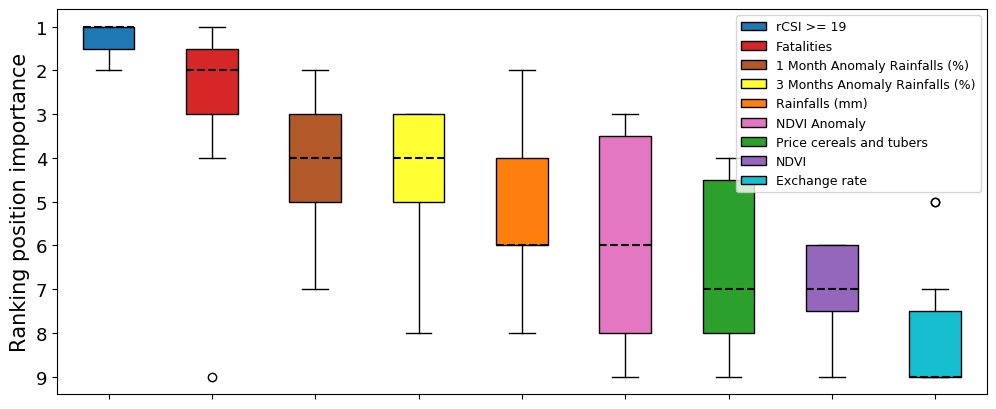

In [13]:
with plt.style.context("default"):
    fig, ax = plt.subplots(figsize = (12, 5))
    T_fcs_rank = T_fcs_rank.astype(int)
    meds = T_fcs_rank.mean()
    meds.sort_values(ascending = True, inplace = True)
    T_fcs_rank_sort = T_fcs_rank[meds.index]
    #T_fcs_rank_sort = T_fcs_rank_sort[['rCSI', 'Fatalities', 'Rainfall (mm)', 'Rainfall Anomaly', 'NDVI Anomaly', 'Price cereals and tubers', 'Exchange rate']]
    #cm = plt.cm.get_cmap("tab20")
    #colors = [cm(val/len(T_fcs_rank_sort.columns)) for val in range(len(T_fcs_rank_sort.columns))]
    bplot = ax.boxplot(T_fcs_rank_sort.T, patch_artist = True, medianprops = {"linestyle": "--", "linewidth": 1.5, "color": "black"}) 
    # Fill with colors.
    legends = list()
    for patch, indicator in zip(bplot["boxes"], T_fcs_rank_sort.columns):
        patch.set_facecolor(colors[indicator])
        patch.set_label(indicator)
        legends.append(patch)
    
    ax.invert_yaxis()
    #ax.set_xlabel("Indicator")
    ax.set_ylabel("Ranking position importance", fontsize = 15)
    ax.tick_params(labelsize = 13)
    ax.set_xticklabels([""]*len(T_fcs_rank_sort.columns), rotation = 0, fontsize = 15)  

    ax.legend(legends, T_fcs_rank_sort.columns, loc = "upper right", prop = {"size": 9})
    
    # Save the figure.
    fig.savefig("./output_images/Ranking_%s.png" % COUNTRY, bbox_inches = "tight", dpi = 300)

# Lag importance

In [14]:
# Compute the entropy rate of the endogenous indicators (FCS indicator)..
lags = 15
def history_length_Y(serie):
    adminstrata = serie.name[0]
    y = list()
    for k in range(lags):
        result = STE.entropy_rate(serie, m = 3, k = k+1, h = 1)
        y.append(result)  
    return y  

tqdm.pandas()
df_results_Y = df.xs("FCG <= 2", axis = 1, level = 1, drop_level = False).progress_apply(history_length_Y)
df_results_Y.index = df_results_Y.index  + 1
df_results_Y.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:20<00:00,  1.90s/it]


AdminStrata,Al-Hasakeh,Aleppo,Ar-Raqqa,As-Sweida,Damascus,Dar'a,Hama,Homs,Lattakia,Rural Damascus,Tartous
Indicator,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2
1,1.215006,1.430900,1.446232,1.295378,1.368610,1.472101,1.431966,1.447096,1.245552,1.400418,1.315931
2,1.168173,1.401014,1.416006,1.259723,1.346774,1.444830,1.405331,1.415268,1.201128,1.359781,1.260848
3,1.091984,1.338883,1.318866,1.175311,1.279122,1.368298,1.334039,1.343821,1.104052,1.259678,1.155693
4,0.925965,1.072579,1.100820,0.983477,1.059579,1.141747,1.130093,1.135079,0.958153,1.029412,0.980987
5,0.696831,0.725950,0.762817,0.736044,0.774791,0.772550,0.813188,0.735139,0.719689,0.790470,0.738926


In [15]:
#df_results_Y = df_results_Y.diff().dropna()

In [16]:
def plot_quantiles(df, title = None, xaxis = None, yaxis = None, label = None):
    with plt.style.context("default"):
        # Define the subplot figure.
        fig, axs = plt.subplots(figsize = (15, 7))
        value_statistic = df.agg([lambda x: x.quantile(0.25), np.mean, lambda x: x.quantile(0.75)], axis = 1)
        value_statistic.columns = ["lower_quantile", "mean", "upper_quantile"]
        # Plot.
        value_statistic["mean"].plot(style = ".-", label = label, ax = axs, ms = 12, c = colors["FCG <= 2"])
        axs.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                         y2 = value_statistic["upper_quantile"], color = colors["FCG <= 2"], alpha = 0.3)
        # Set attributes of the plot.
        axs.set_title(title)
        axs.legend(loc = "best", prop = {"size": 15})
        axs.set_xlabel(xaxis, fontsize = 18)
        axs.set_ylabel(yaxis, fontsize = 18)
        axs.tick_params(labelsize = 15)
        axs.set_xticks(np.arange(1, 16))
    return fig, axs

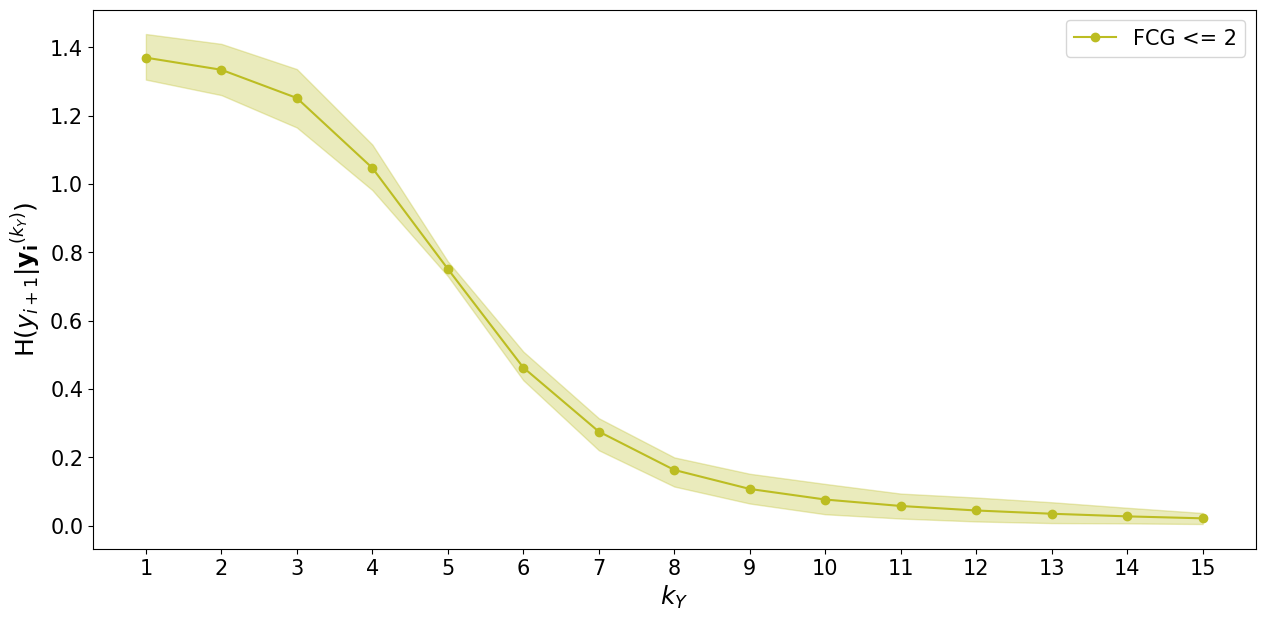

In [17]:
fig, axs = plot_quantiles(df_results_Y, xaxis = "$k_{Y}$", yaxis = "H($y_{i+1}|\mathbf{y_{i}}^{(k_Y)}$)", label = "FCG <= 2")

In [18]:
fig.savefig("./output_images/entropy_rate_%s.png" % COUNTRY, bbox_inches = "tight", dpi = 300)

In [19]:
# Select only the exogenous indicators.
df_no_fcs = df.drop(columns = ["FCG <= 2"], axis = 1, level = 1)
df_no_fcs.head()

AdminStrata                    Al-Hasakeh                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
Datetime                                                                   
2018-09-29                      99.920932                     103.281473   
2018-09-30                      99.894768                     102.581411   
2018-10-01                      99.936859                     102.137474   
2018-10-02                     100.047045                     101.810225   
2018-10-03                     100.225326                     101.599662   

AdminStrata                                                  \
Indicator   Exchange rate Fatalities      NDVI NDVI Anomaly   
Datetime                                                      
2018-09-29       0.017435      111.0  0.117052    89.349382   
2018-09-30       0.017595      101.0  0.116985    89.326130   
2018-10-01       0.017870       99.0  0.116915    89.301813   
2018-10-02       0.017985       97.0  0.116842    89.275320   
2018-10-03       0.018099       85.0  0.116765    89.246651   

AdminStrata                                                     \
Indicator   Price cereals and tubers Rainfalls (mm) rCSI >= 19   
Datetime                                                         
2018-09-29                  0.057275         0.1372   34.05440   
2018-09-30                  0.057331         0.1500   34.05440   
2018-10-01                  0.057651         0.7876   33.67614   
2018-10-02                  0.057914         1.4245   31.54574   
2018-10-03                  0.058178         2.0614   32.76720   

AdminStrata                        Aleppo  ... Rural Damascus  \
Indicator   1 Month Anomaly Rainfalls (%)  ...     rCSI >= 19   
Datetime                                   ...                  
2018-09-29                     105.993454  ...      35.367942   
2018-09-30                     106.154101  ...      35.821018   
2018-10-01                     106.310695  ...      35.846059   
2018-10-02                     106.443678  ...      36.688419   
2018-10-03                     106.553050  ...      36.086356   

AdminStrata                       Tartous                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
Datetime                                                                   
2018-09-29                     113.829315                     179.577637   
2018-09-30                     113.631431                     173.128816   
2018-10-01                     113.462981                     166.727201   
2018-10-02                     113.241732                     160.712897   
2018-10-03                     112.967684                     155.085903   

AdminStrata                                                  \
Indicator   Exchange rate Fatalities      NDVI NDVI Anomaly   
Datetime                                                      
2018-09-29       0.016755       24.0  0.445703   114.296330   
2018-09-30       0.016900       24.0  0.445190   114.196334   
2018-10-01       0.017122       24.0  0.444679   114.087915   
2018-10-02       0.017198       24.0  0.444170   113.971913   
2018-10-03       0.017275       24.0  0.443665   113.848328   

AdminStrata                                                     
Indicator   Price cereals and tubers Rainfalls (mm) rCSI >= 19  
Datetime                                                        
2018-09-29                  0.146942         7.9716   27.31994  
2018-09-30                  0.149815         8.1647   26.22302  
2018-10-01                  0.152405        10.0496   25.22491  
2018-10-02                  0.152121        11.5057   27.92877  
2018-10-03                  0.151837        12.9618   27.08270  

[5 rows x 99 columns]

In [20]:
lags = 15

In [21]:
def history_length_X(serie):
    adminstrata = serie.name[0]
    indicator = serie.name[1]
    y = list()
    for k in range(lags):
        result = STE.calc_ste(serie, df[adminstrata]["FCG <= 2"], m = 3, kx = k+1, ky = 1, h = 1)
        y.append(result)        
    return y  

tqdm.pandas()
df_results_X = df_no_fcs.progress_apply(history_length_X)
df_results_X.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [02:36<00:00,  1.58s/it]


AdminStrata                    Al-Hasakeh                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
0                                0.047683                       0.036702   
1                                0.072805                       0.063006   
2                                0.098676                       0.088280   
3                                0.134219                       0.114490   
4                                0.155128                       0.136671   

AdminStrata                                                  \
Indicator   Exchange rate Fatalities      NDVI NDVI Anomaly   
0                0.027276   0.075757  0.031327     0.052839   
1                0.031175   0.177747  0.041478     0.072437   
2                0.036520   0.367324  0.043862     0.081754   
3                0.037655   0.558989  0.055036     0.098306   
4                0.038143   0.740748  0.060612     0.108140   

AdminStrata                                                     \
Indicator   Price cereals and tubers Rainfalls (mm) rCSI >= 19   
0                           0.030922       0.031388   0.097754   
1                           0.043492       0.056049   0.275810   
2                           0.060029       0.078843   0.547151   
3                           0.070270       0.095641   0.749904   
4                           0.085752       0.115673   0.904229   

AdminStrata                        Aleppo  ... Rural Damascus  \
Indicator   1 Month Anomaly Rainfalls (%)  ...     rCSI >= 19   
0                                0.046673  ...       0.054618   
1                                0.070296  ...       0.211388   
2                                0.100269  ...       0.477463   
3                                0.134867  ...       0.791796   
4                                0.159444  ...       1.039675   

AdminStrata                       Tartous                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
0                                0.039624                       0.036729   
1                                0.063614                       0.070137   
2                                0.077279                       0.096845   
3                                0.100437                       0.121177   
4                                0.120735                       0.141358   

AdminStrata                                                  \
Indicator   Exchange rate Fatalities      NDVI NDVI Anomaly   
0                0.029767   0.015094  0.029292     0.017160   
1                0.043573   0.019793  0.039446     0.030755   
2                0.054328   0.027089  0.054294     0.043733   
3                0.068620   0.031575  0.066181     0.051904   
4                0.081246   0.035897  0.079469     0.063579   

AdminStrata                                                     
Indicator   Price cereals and tubers Rainfalls (mm) rCSI >= 19  
0                           0.023917       0.040804   0.070001  
1                           0.037713       0.062275   0.235626  
2                           0.044901       0.083361   0.478355  
3                           0.061493       0.107284   0.780617  
4                           0.073964       0.128566   0.983162  

[5 rows x 99 columns]

In [22]:
df_results_X = df_results_X.diff().dropna()

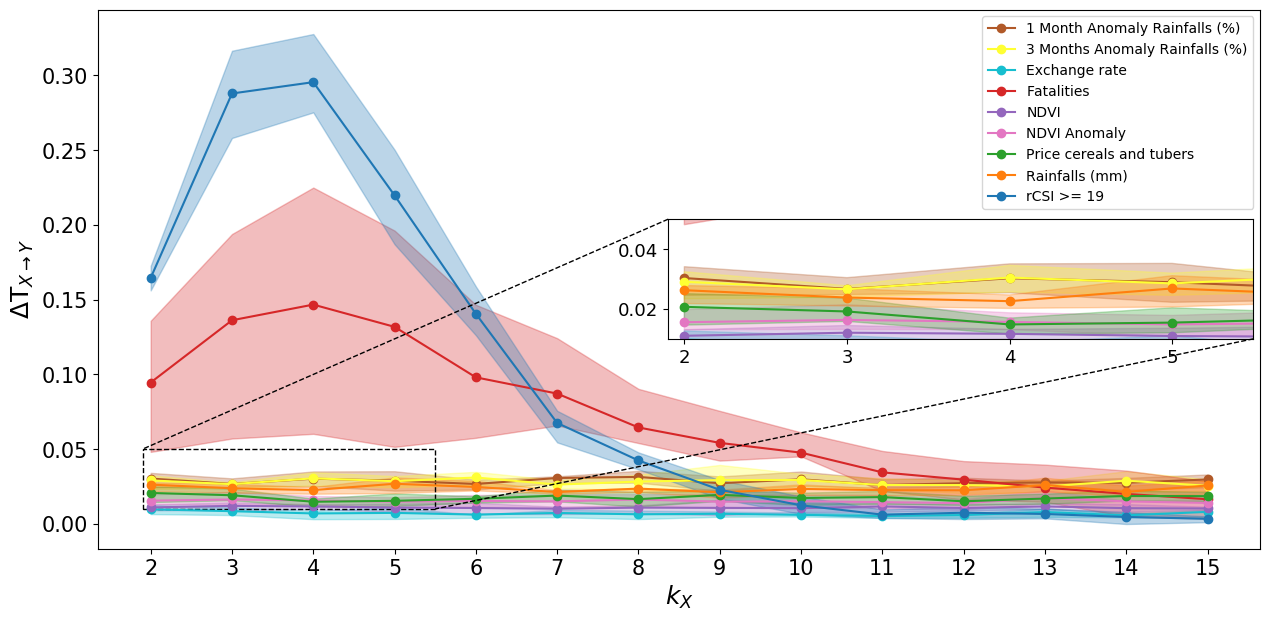

In [23]:
with plt.style.context("default"):
    # Define the subplot figure.
    fig, axs = plt.subplots(figsize = (15, 7))
    axins = zoomed_inset_axes(axs, 2., loc = "right")
    for i,indicator in enumerate(df_results_X.columns.get_level_values(1).unique()):
        subdf = df_results_X.xs(indicator, axis = 1, level = 1, drop_level = False)
        subdf.index = subdf.index + 1
        value_statistic = subdf.agg([lambda x: x.quantile(0.25), np.mean, lambda x: x.quantile(0.75)], axis = 1)
        value_statistic.columns = ["lower_quantile", "mean", "upper_quantile"]
        # Plot.
        value_statistic["mean"].plot(style = ".-", label = indicator, ax = axs, ms = 12, c = colors[indicator])
        value_statistic["mean"].plot(style = ".-", label = indicator, ax = axins, ms = 12, c = colors[indicator])
        axs.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                         y2 = value_statistic["upper_quantile"], color = colors[indicator], alpha = 0.3)
        axins.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                           y2 = value_statistic["upper_quantile"], color = colors[indicator], alpha = 0.3)
        axins.set_xticks(np.arange(1, 6))
        axins.tick_params(labelsize = 13)
        # Set attributes of the plot.
        axs.legend(loc = "best", prop = {"size": 10})
        axs.set_xlabel("$k_{X}$", fontsize = 18)
        axs.set_ylabel(r'$\Delta$T$_{X \rightarrow Y}$', fontsize = 18)
        axs.tick_params(labelsize = 15)
        axs.set_xticks(np.arange(2, 16))

    axins.set_xlim(1.9, 5.5)
    axins.set_ylim(0.01, 0.05)
    mark_inset(axs, axins, loc1 = 2, loc2 = 4, fc = "none", ec = "black", linestyle  = "--")
    # Save the figure.
    fig.savefig("./output_images/Lags_%s.png" % COUNTRY, bbox_inches = "tight", dpi = 300)